# Regression - How much to bet

This notebook is for model building of the regression model to predict the amount to bet.

<u>***Setup***</u>

In [1]:
import os,copy
import sqlite3 as sql
import numpy as np

import pandas as pd
from IPython.display import display, Math, Latex
from matplotlib import pyplot as plt

import torch as tc
from torch.utils.data.sampler import SubsetRandomSampler
import tqdm

## Pulling data

This is simply to connect to the db and pull the data to see what it looks like

In [2]:
# Specify the absolute path to the database file
db_file_path = '../data/game_state.db'

# Check if the database file exists
if os.path.exists(db_file_path):
    conn = sql.connect(db_file_path)
    bet_df = pd.read_sql_query('SELECT * FROM players_bet', conn)
else:
    print("Database file not found.")


In [3]:
print(f"{bet_df.shape=}")
bet_df.head()

bet_df.shape=(301, 12)


,game_ID,roundNumber,player_name,player_is_pc,player_cards,player_hand,player_bet,house_name,house_visible_card,house_visible_hand,game_pot,round_initial_bet
0,d9dfe2f1-826e-4ab1-9d40-439b2d613905,0,Joe,0,"(Di 2,Sp A)",13,70,House,Hr 7,7,70,50
1,d9dfe2f1-826e-4ab1-9d40-439b2d613905,0,Albert,0,"(Hr 2,Sp K)",12,70,House,Hr 7,7,140,50
2,d9dfe2f1-826e-4ab1-9d40-439b2d613905,0,PC-1,1,"(Hr 6,Di 9)",15,75,House,Hr 7,7,215,50
3,d9dfe2f1-826e-4ab1-9d40-439b2d613905,1,Joe,0,"(Cl 10,Hr 6)",16,50,House,Sp A,11,50,50
4,d9dfe2f1-826e-4ab1-9d40-439b2d613905,1,Albert,0,"(Cl A,Sp 3)",14,50,House,Sp A,11,100,50


## Data manipulation

In this section I am creating the input $X$ for the regression I will be using.

In [4]:
bet_df.sort_values(by='player_hand',ascending=False).head()

,game_ID,roundNumber,player_name,player_is_pc,player_cards,player_hand,player_bet,house_name,house_visible_card,house_visible_hand,game_pot,round_initial_bet
20,f8ee0a9c-0288-4407-86de-cc0a49531194,1,Albert,0,"(Sp 10,Di 4,Di 10)",24,140,House,Cl 4,4,140,50
29,f8ee0a9c-0288-4407-86de-cc0a49531194,4,Joe,0,"(Sp 8,Cl 5,Hr K)",23,150,House,Cl 8,8,75,75
15,f8ee0a9c-0288-4407-86de-cc0a49531194,0,Joe,0,"(Hr 9,Sp 4,Cl 10)",23,140,House,Di 7,7,70,50
98,05bc6b82-abe6-44d7-b928-50d6e3cd910c,4,Albert,0,"(Cl 4,Sp 9,Di 10)",23,150,House,Hr J,10,150,75
61,d06a7041-d5e2-46de-9c79-10bb2745b7a6,8,Joe,0,"(Di 3,Sp 9,Sp 10)",22,250,House,Cl 9,9,125,125


In [5]:
# bet_grp_df = bet_df.groupby(['game_ID','roundNumber']).agg({'game_pot':'sum'}).reset_index().head()
bet_df['round_pot'] = bet_df.groupby(['game_ID','roundNumber'])['game_pot'].transform('max')
bet_df.sort_values(['game_ID','roundNumber']).head(5)

,game_ID,roundNumber,player_name,player_is_pc,player_cards,player_hand,player_bet,house_name,house_visible_card,house_visible_hand,game_pot,round_initial_bet,round_pot
206,045543fa-062c-4971-972c-6a917e00fcb5,0,Joe,0,"(Cl K,Di 3)",13,70,House,Di 7,7,70,50,205
207,045543fa-062c-4971-972c-6a917e00fcb5,0,Albert,0,"(Sp K,Sp 8)",18,70,House,Di 7,7,140,50,205
208,045543fa-062c-4971-972c-6a917e00fcb5,0,PC-1,1,"(Hr Q,Hr 2)",12,65,House,Di 7,7,205,50,205
209,045543fa-062c-4971-972c-6a917e00fcb5,1,Joe,0,"(Sp 5,Sp 8)",13,50,House,Sp 9,9,50,50,151
210,045543fa-062c-4971-972c-6a917e00fcb5,1,Joe,0,"(Sp 5,Sp 8)",13,50,House,Sp 9,9,50,50,151


In [6]:
select_cols = ['player_cards','player_hand','card_1','card_2','house_visible_hand','house_card','player_bet']
bet_df['house_card'] = bet_df.house_visible_card.str.split().str[1]
bet_df[['card_1','card_2']] = bet_df.player_cards.str.replace("(","").str.replace(")","").str.split(",",n=1,expand=True)
bet_df['card_1'] = bet_df['card_1'].str.split().str[1]
bet_df['card_2'] = bet_df['card_2'].str.split().str[1]
bet_df[select_cols].head()

,player_cards,player_hand,card_1,card_2,house_visible_hand,house_card,player_bet
0,"(Di 2,Sp A)",13,2,A,7,7,70
1,"(Hr 2,Sp K)",12,2,K,7,7,70
2,"(Hr 6,Di 9)",15,6,9,7,7,75
3,"(Cl 10,Hr 6)",16,10,6,11,A,50
4,"(Cl A,Sp 3)",14,A,3,11,A,50


<Axes: xlabel='house_visible_hand', ylabel='player_bet'>

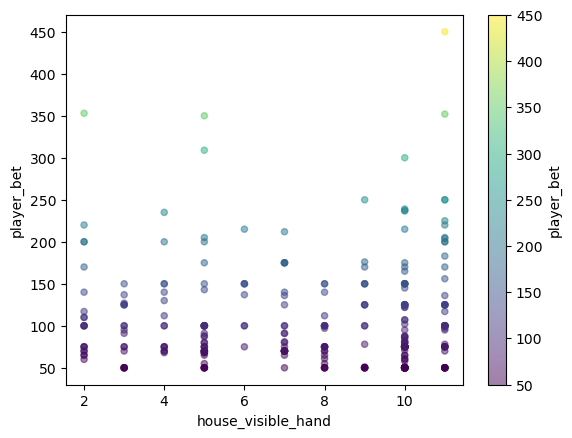

In [7]:
bet_df.plot.scatter(y='player_bet', x='house_visible_hand', c='player_bet', colormap='viridis', alpha=0.5)

In [8]:
bet_df[['player_bet','round_pot','player_hand','house_visible_hand']].corr()

,player_bet,round_pot,player_hand,house_visible_hand
player_bet,1.000000,0.775138,0.138716,-0.001513
round_pot,0.775138,1.000000,-0.005406,0.007937
player_hand,0.138716,-0.005406,1.000000,-0.057000
house_visible_hand,-0.001513,0.007937,-0.057000,1.000000


Unfortunately, `round_pot` cannot be used for the regression. It is a leaky feature. There is a good correlation here though...

## Mathematical modeling

Here is the math behind linear regression, and **this formulation will remain constant <u>regardless</u> of what $A$ is a representation** of:

$$
\begin{align}
Ax & = y \\
A^TAx & = A^Ty \\
(A^TA)^{-1}(A^TA)x  & = (A^TA)^{-1}A^Ty \\
x & = (A^TA)^{-1}A^Ty
\end{align}
$$

Another way to derive this equation is with the ***least square error*** derivation:

$$
\begin{align}
(Ax - y)^2 & = 0 \\
\therefore (Ax - y)^2\frac{\partial}{\partial x} = 2A^T(Ax - y)  & = 0 \\
A^TAx & = A^Ty \\
(A^TA)^{-1}(A^TA)x  & = (A^TA)^{-1}A^Ty \\
x & = (A^TA)^{-1}A^Ty
\end{align}
$$

The ***LSE***-formulation does prove that the last equation is an optimal solution for determining $x$.

## Input modeling/representation

There are a couple of ways to model this:

1. Making a 'dummy'-variable on the cards of the player and representing that as a vector
2. Adding an additional vector for the visible house card and making it a negative sign
3. Using the player's hand as is
4. Adding the visible house hand as is


### Sampling
First I need to make a homoscadastic sample. This is achieved by simply shuffling the dataframe. The reason is, as the game continues in general, the stakes get higher. Hence the amount that each player bets, is upped artificially and therefore the relation between the `house_visible_hand` and the `player_bet` gets distorted.

A further compounding effect is the `double-down` feature. Which is an additional bet, *after* the player has seen their cards.

Original df


,game_ID,roundNumber,player_name,player_is_pc,player_cards,player_hand,player_bet,house_name,house_visible_card,house_visible_hand,game_pot,round_initial_bet,round_pot,house_card,card_1,card_2
0,d9dfe2f1-826e-4ab1-9d40-439b2d613905,0,Joe,0,"(Di 2,Sp A)",13,70,House,Hr 7,7,70,50,215,7,2,A
1,d9dfe2f1-826e-4ab1-9d40-439b2d613905,0,Albert,0,"(Hr 2,Sp K)",12,70,House,Hr 7,7,140,50,215,7,2,K
2,d9dfe2f1-826e-4ab1-9d40-439b2d613905,0,PC-1,1,"(Hr 6,Di 9)",15,75,House,Hr 7,7,215,50,215,7,6,9
3,d9dfe2f1-826e-4ab1-9d40-439b2d613905,1,Joe,0,"(Cl 10,Hr 6)",16,50,House,Sp A,11,50,50,195,A,10,6
4,d9dfe2f1-826e-4ab1-9d40-439b2d613905,1,Albert,0,"(Cl A,Sp 3)",14,50,House,Sp A,11,100,50,195,A,A,3


Shuffle_df


,game_ID,roundNumber,player_name,player_is_pc,player_cards,player_hand,player_bet,house_name,house_visible_card,house_visible_hand,game_pot,round_initial_bet,round_pot,house_card,card_1,card_2
0,e987a9a4-c081-4bda-8b1f-7f1fc55087f6,5,Joe,0,"(Hr A,Hr 2)",13,100,House,Hr 5,5,100,100,343,5,A,2
1,f8ee0a9c-0288-4407-86de-cc0a49531194,1,Albert,0,"(Sp 10,Di 4)",14,70,House,Cl 4,4,140,50,208,4,10,4
2,e987a9a4-c081-4bda-8b1f-7f1fc55087f6,2,Joe,0,"(Cl 5,Cl Q)",15,50,House,Di J,10,50,50,195,J,5,Q
3,045543fa-062c-4971-972c-6a917e00fcb5,1,Joe,0,"(Sp 5,Sp 8)",13,50,House,Sp 9,9,50,50,151,9,5,8
4,05bc6b82-abe6-44d7-b928-50d6e3cd910c,3,Joe,0,"(Di 3,Di 5)",8,75,House,Sp K,10,75,75,252,K,3,5


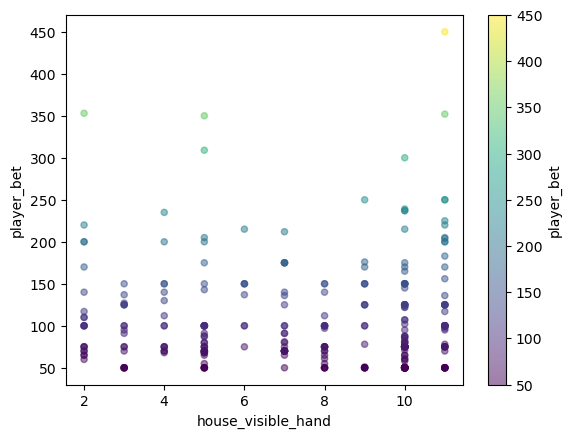

In [9]:
shuffle_df = bet_df.sample(n=len(bet_df)).reset_index(drop=True).copy()
shuffle_df.plot.scatter(y='player_bet', x='house_visible_hand', c='player_bet', colormap='viridis', alpha=0.5)
print("Original df")
display(bet_df.head())
print("Shuffle_df")
display(shuffle_df.head())

### 1. Dummy variable with players hand only

In [10]:
def check_and_order_columns(df,ordered_list):
    df_cols = df.columns; df_rows, _ = df.shape
    mis_cols = [c for c in ordered_list if c not in df_cols]
    if len(mis_cols) > 0:
        for mc in mis_cols:
            df[mc] = np.zeros(df_rows).astype(int)
    return (mis_cols, df[ordered_list].copy())

In [11]:

# Creating data indices for training and validation splits:
validation_split = 0.5
dataset_size = len(shuffle_df)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
# np.random.seed(random_seed)
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_df = shuffle_df.iloc[train_indices]
test_df = shuffle_df.iloc[val_indices]
X_train_df, y_train = train_df.drop('player_bet',axis=1), train_df['player_bet']
X_test_df, y_test = test_df.drop('player_bet',axis=1), test_df['player_bet']

X_train = pd.get_dummies(X_train_df.house_card).astype(int)
X_test = pd.get_dummies(X_test_df.house_card).astype(int)
mis_cols_train, X_train = check_and_order_columns(X_train,['2','3','4','5','6','7','8','9','10','J','Q','K','A'])
mis_cols_test, X_test = check_and_order_columns(X_test,['2','3','4','5','6','7','8','9','10','J','Q','K','A'])
print(f"X_train [{X_train.shape=}] ({mis_cols_train=})")
display(X_train.head())
print(f"X_test [{X_test.shape=}] ({mis_cols_test=})")
display(X_test.head())


X_train [X_train.shape=(151, 13)] (mis_cols_train=[])


,2,3,4,5,6,7,8,9,10,J,Q,K,A
141,0,0,0,0,0,0,0,0,0,0,1,0,0
160,0,0,0,0,0,1,0,0,0,0,0,0,0
98,0,0,0,0,0,1,0,0,0,0,0,0,0
222,0,0,0,0,0,0,0,1,0,0,0,0,0
34,0,0,0,0,0,0,0,0,0,0,1,0,0


X_test [X_test.shape=(150, 13)] (mis_cols_test=[])


,2,3,4,5,6,7,8,9,10,J,Q,K,A
61,1,0,0,0,0,0,0,0,0,0,0,0,0
75,1,0,0,0,0,0,0,0,0,0,0,0,0
203,0,0,0,0,0,0,0,1,0,0,0,0,0
221,0,0,0,0,0,0,0,0,1,0,0,0,0
286,0,0,0,0,0,0,0,0,0,0,0,1,0


Below is just checking if the addition above worked correctly..

In [12]:
### This was again built off a previous game version
# player_input_df.iloc[bet_df.loc[bet_df.card_1 == bet_df.card_2].index].head()

Now, coding ***LSE***-formulation with python, specifically using pytorch, looks like this:


a_train_sse=tensor(446717.7812)

a_test_sse=tensor(548791.)


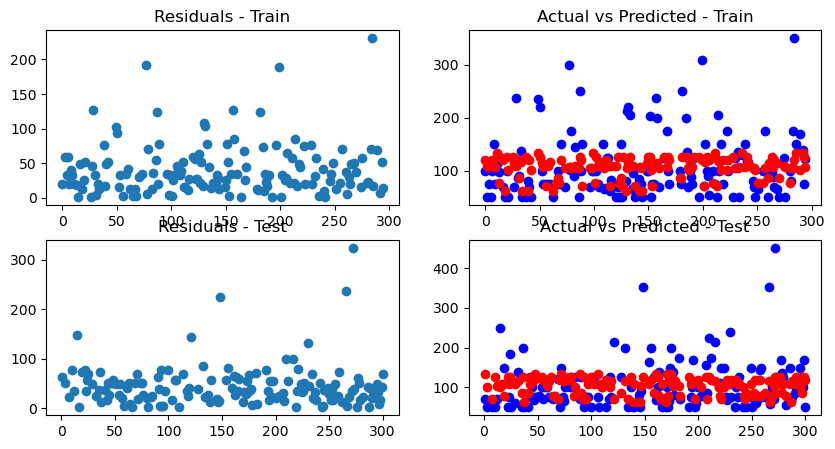

In [13]:
A = tc.tensor(X_train.values, dtype=tc.float32)
x = (tc.linalg.inv((A.t() @ A) + tc.eye(n=A.shape[1])*0.1)@A.t())@tc.tensor(y_train.values, dtype=tc.float32)
## Training results
a_train_resid = tc.sqrt((A@x - tc.tensor(y_train.values, dtype=tc.float32))**2)
a_train_sse = tc.sum(a_train_resid**2)

## Testing results
B = tc.tensor(X_test.values, dtype=tc.float32)
a_test_resid = tc.sqrt((B@x - tc.tensor(y_test.values, dtype=tc.float32))**2)
a_test_sse = tc.sum(a_test_resid**2)

print(f"\n{a_train_sse=}")
print(f"\n{a_test_sse=}")

fig, ax = plt.subplots(2,2,figsize=(10,5))
ax[0][0].scatter(x=y_train.index,y=a_train_resid)
ax[0][0].set_title('Residuals - Train')
ax[0][1].scatter(x=y_train.index,y=y_train, c='b', label='Actual')
ax[0][1].scatter(x=y_train.index,y=A@x, c='r', label='Predicted')
ax[0][1].set_title('Actual vs Predicted - Train')
ax[1][0].scatter(x=y_test.index,y=a_test_resid)
ax[1][0].set_title('Residuals - Test')
ax[1][1].scatter(x=y_test.index,y=y_test, c='b', label='Actual')
ax[1][1].scatter(x=y_test.index,y=B@x, c='r', label='Predicted')
ax[1][1].set_title('Actual vs Predicted - Test')
plt.show()


### 2. Dummy variables including House-hand

This model can not be used, as these inputs are not available when the bet is made. However, it will be interesting to see what happens here...

In [14]:
player_house_train_df = pd.get_dummies(X_train_df.card_1).astype(int)
player_house_test_df = pd.get_dummies(X_test_df.card_1).astype(int)
player_house_train_df = player_house_train_df.add(pd.get_dummies(X_train_df.card_2).astype(int), fill_value=0)
player_house_test_df = player_house_test_df.add(pd.get_dummies(X_test_df.card_2).astype(int), fill_value=0)
player_house_train_df = player_house_train_df.add(pd.get_dummies(X_train_df.house_card).astype(int)*-0.25, fill_value=0)
player_house_test_df = player_house_test_df.add(pd.get_dummies(X_test_df.house_card).astype(int)*-0.25, fill_value=0)
mis_cols_ph_train, player_house_train_df = check_and_order_columns(player_house_train_df,['2','3','4','5','6','7','8','9','10','J','Q','K','A'])
mis_cols_ph_test, player_house_test_df = check_and_order_columns(player_house_test_df,['2','3','4','5','6','7','8','9','10','J','Q','K','A'])

print(f"X_train ({mis_cols_ph_train=})")
display(player_house_train_df.head())
print(f"X_test ({mis_cols_ph_test=})")
display(player_house_test_df.head())


X_train (mis_cols_ph_train=[])


,2,3,4,5,6,7,8,9,10,J,Q,K,A
141,0.0,0.0,0.0,0.0,0.0,0.00,0.0,2.00,0.0,0.0,-0.25,0.0,0.0
160,0.0,0.0,1.0,0.0,0.0,-0.25,0.0,1.00,0.0,0.0,0.00,0.0,0.0
98,0.0,0.0,1.0,0.0,0.0,-0.25,0.0,0.00,1.0,0.0,0.00,0.0,0.0
222,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.75,1.0,0.0,0.00,0.0,0.0
34,0.0,0.0,0.0,0.0,1.0,0.00,0.0,0.00,0.0,0.0,0.75,0.0,0.0


X_test (mis_cols_ph_test=[])


,2,3,4,5,6,7,8,9,10,J,Q,K,A
61,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,1.0,0.00,0.0
75,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,1.0,0.00,0.0
203,0.00,0.0,0.0,0.0,1.0,0.0,0.0,-0.25,0.00,1.0,0.0,0.00,0.0
221,1.00,0.0,1.0,0.0,0.0,0.0,0.0,0.00,-0.25,0.0,0.0,0.00,0.0
286,0.00,1.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,-0.25,0.0



c_train_sse=tensor(639251.3125)

d_test_sse=tensor(691735.8125)


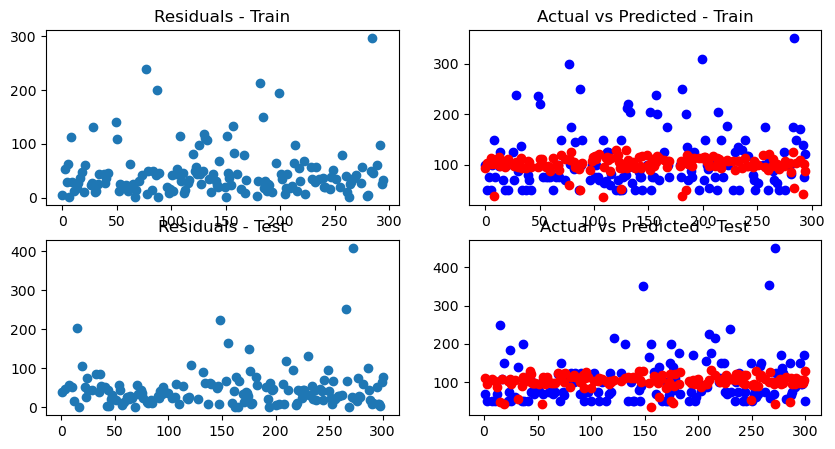

In [15]:
C = tc.tensor(player_house_train_df.values, dtype=tc.float32)
x = (tc.linalg.inv((C.t() @ C) + tc.eye(n=C.shape[1])*0.1)@C.t())@tc.tensor(y_train.values, dtype=tc.float32)
## Training results
c_train_resid = tc.sqrt((C@x - tc.tensor(y_train.values, dtype=tc.float32))**2)
c_train_sse = tc.sum(c_train_resid**2)

## Testing results
D = tc.tensor(player_house_test_df.values, dtype=tc.float32)
d_test_resid = tc.sqrt((D@x - tc.tensor(y_test.values, dtype=tc.float32))**2)
d_test_sse = tc.sum(d_test_resid**2)

print(f"\n{c_train_sse=}")
print(f"\n{d_test_sse=}")

fig, ax = plt.subplots(2,2,figsize=(10,5))
ax[0][0].scatter(x=y_train.index,y=c_train_resid)
ax[0][0].set_title('Residuals - Train')
ax[0][1].scatter(x=y_train.index,y=y_train, c='b', label='Actual')
ax[0][1].scatter(x=y_train.index,y=C@x, c='r', label='Predicted')
ax[0][1].set_title('Actual vs Predicted - Train')
ax[1][0].scatter(x=y_test.index,y=d_test_resid)
ax[1][0].set_title('Residuals - Test')
ax[1][1].scatter(x=y_test.index,y=y_test, c='b', label='Actual')
ax[1][1].scatter(x=y_test.index,y=D@x, c='r', label='Predicted')
ax[1][1].set_title('Actual vs Predicted - Test')
plt.show()

## Neural net

This is a simple Neural net which will generate a regression output.

I am building the model off of [this blog post](https://machinelearningmastery.com/building-a-regression-model-in-pytorch/)

The first thing is to setup the model and its configs:

In [16]:
layers = [13]
# layers.extend([36,18,9,1])
# layers.extend([24,12,6,1])
layers.extend([48,24,12,1])
# layers.extend([92,48,24,12,24,48,12,1])
act_func = tc.nn.ReLU()

fnn_layers = [layers[i:(i+2)] for i in np.arange(len(layers)-1)]
fnn_layers = [[tc.nn.Linear(i,j),act_func] for i,j in fnn_layers]
fnn_layers = [item for el in fnn_layers for item in el]
# fnn_layers

## Model setup
model = tc.nn.Sequential(
    *fnn_layers[:-1]
)

loss_func = tc.nn.MSELoss()
optimizer = tc.optim.Adam(model.parameters(),lr=1e-3)

print(model)

Sequential(
  (0): Linear(in_features=13, out_features=48, bias=True)
  (1): ReLU()
  (2): Linear(in_features=48, out_features=24, bias=True)
  (3): ReLU()
  (4): Linear(in_features=24, out_features=12, bias=True)
  (5): ReLU()
  (6): Linear(in_features=12, out_features=1, bias=True)
)


Now setting up the experiment parameters and data

In [17]:
## Data -  Convert to 2D PyTorch tensors
X_train_tc = tc.tensor(X_train.values, dtype=tc.float32)
y_train_tc = tc.tensor(y_train.values, dtype=tc.float32).reshape(-1, 1)
X_test_tc = tc.tensor(X_test.values, dtype=tc.float32)
y_test_tc = tc.tensor(y_test.values, dtype=tc.float32).reshape(-1, 1)


## Experiment settings
n_epochs = 100
batch_size = 10
batch_start = tc.arange(0, len(X_train_tc), batch_size)


## Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []


Now running the experiment

MSE: 3500.61
RMSE: 59.17


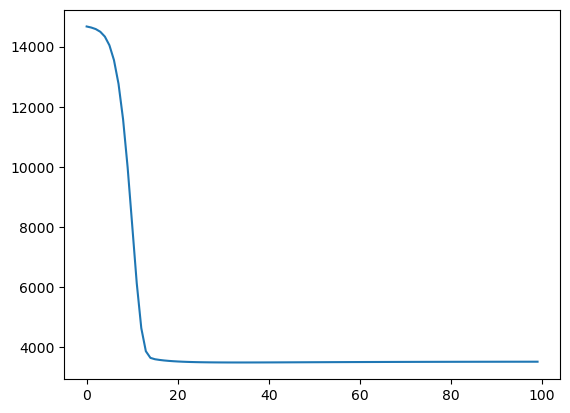

In [18]:
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train_tc[start:start+batch_size]
            y_batch = y_train_tc[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_func(y_pred, y_batch)
            # loss = tc.sqrt(loss_func(y_pred, y_batch))
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test_tc)
    mse = loss_func(y_pred, y_test_tc)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

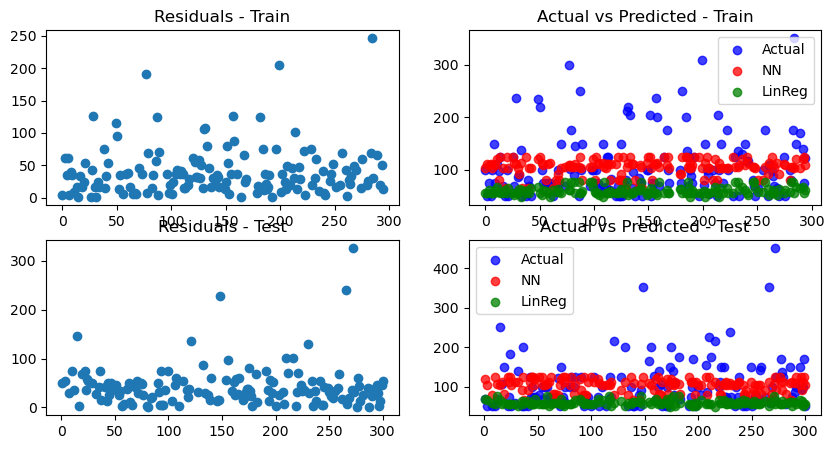

In [19]:
train_resid_tc = tc.sqrt((model(X_train_tc) - tc.tensor(y_train.values, dtype=tc.float32).reshape(-1,1))**2)
test_resid_tc = tc.sqrt((model(X_test_tc) - tc.tensor(y_test.values, dtype=tc.float32).reshape(-1,1))**2)
alpha=0.75


fig, ax = plt.subplots(2,2,figsize=(10,5))
ax[0][0].scatter(x=y_train.index,y=train_resid_tc.detach().numpy())
ax[0][0].set_title('Residuals - Train')
ax[0][1].scatter(x=y_train.index,y=y_train, c='b', label='Actual', alpha=alpha)
ax[0][1].scatter(x=y_train.index,y=model(X_train_tc).detach().numpy(), c='r', label='NN',alpha=alpha)
ax[0][1].scatter(x=y_train.index,y=A@x, c='g', label='LinReg',alpha=alpha)
ax[0][1].legend()
ax[0][1].set_title('Actual vs Predicted - Train')
ax[1][0].scatter(x=y_test.index,y=test_resid_tc.detach().numpy())
ax[1][0].set_title('Residuals - Test')
ax[1][1].scatter(x=y_test.index,y=y_test, c='b', label='Actual',alpha=alpha)
ax[1][1].scatter(x=y_test.index,y=model(X_test_tc).detach().numpy(), c='r', label='NN',alpha=alpha)
ax[1][1].scatter(x=y_test.index,y=B@x, c='g', label='LinReg',alpha=alpha)
ax[1][1].legend()
ax[1][1].set_title('Actual vs Predicted - Test')
plt.show()

In [20]:
describe_df = pd.DataFrame(model(X_test_tc).detach().numpy()).describe()
describe_df.columns = ['NN']
describe_df['LinReg'] = pd.DataFrame(B@x).describe()
describe_df['diff_NNMinLinReg'] = describe_df['NN'] - describe_df['LinReg']
describe_df.head(10)

,NN,LinReg,diff_NNMinLinReg
count,150.000000,150.000000,0.000000
mean,103.499138,59.442677,44.056461
std,16.607738,5.848652,10.759086
min,65.841988,47.808388,18.033600
25%,92.558464,55.995251,36.563213
50%,106.281410,57.494793,48.786617
75%,113.005043,62.498055,50.506989
max,124.689125,76.512054,48.177071


# Conclusion

There is no real other model that I can play here than the regression model I stated above. it also actually seems as though that works relatively well.

I tried the NN for this regression problem - however it is not generalizing well, and it may be due to the fact that there is not enough data to learn the parameters well.